# Set up a simple queue of SBs to run a real-time ARL pipeline, outputting QA to a TM queue.

In [1]:
import queue

import numpy

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u

from arl.data_models.polarisation import PolarisationFrame

from arl.processing_components import create_skycomponent, create_blockvisibility_iterator, create_named_configuration, \
    qa_gaintable, rcal

import logging
mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 



Define the data to be generated

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')
times = numpy.linspace(-3.0, +3.0, 7) * numpy.pi / 12.0
frequency = numpy.linspace(1.0e8, 1.50e8, 3)
channel_bandwidth = numpy.array([5e7, 5e7, 5e7])

# Define the component and give it some polarisation and spectral behaviour
f = numpy.array([100.0, 20.0, -10.0, 1.0])
flux = numpy.array([f, 0.8 * f, 0.6 * f])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
compdirection = SkyCoord(ra=17.0 * u.deg, dec=-36.5 * u.deg, frame='icrs', equinox='J2000')
comp = create_skycomponent(flux=flux, frequency=frequency, direction=compdirection)

In [3]:
def plotgain(gt, title=''):
    plt.clf()
    plt.plot(numpy.real(gt.gain[...,0,0]).flat, numpy.imag(gt.gain[...,0,0]).flat, '.')
    plt.plot(numpy.real(gt.gain[...,1,1]).flat, numpy.imag(gt.gain[...,1,1]).flat, '.')
    plt.title(title)
    plt.xlabel('Real part of gain')
    plt.ylabel('Imaginary part of gain')
    plt.show()

Create two queues, an input and output. Call them CSP (in) and TM (out).

In [4]:
csp_queue = queue.Queue()
tm_queue = queue.Queue()

Now populate the CSP queue with 3 "Measurements".

In [5]:
num_tasks_to_queue = 3
for i in range(num_tasks_to_queue):
    sb_id = i+100000
    data = [sb_id, create_blockvisibility_iterator(lowcore, times=times,
                                             frequency=frequency,
                                             channel_bandwidth=channel_bandwidth, phasecentre=phasecentre,
                                             weight=1, polarisation_frame=PolarisationFrame('linear'),
                                             integration_time=1.0, number_integrations=1,
                                             components=comp, phase_error=0.1, amplitude_error=0.01)]
    csp_queue.put(data)

Can view the queue contents, if desired. Essentially an SDP Jobs List.

In [6]:
for elem in list(csp_queue.queue):
    print(elem)

[100000, <generator object create_blockvisibility_iterator at 0x129afdc00>]
[100001, <generator object create_blockvisibility_iterator at 0x129afdb10>]
[100002, <generator object create_blockvisibility_iterator at 0x129afdcf0>]


Can iterate over the queue, to process those jobs (non-prioritised).

Processing SB_ID: 100000 ( 2 items left in CSP queue )
Starting pipeline
Ingest and RCAL pipelines are empty, stopping
Processing SB_ID: 100001 ( 1 items left in CSP queue )
Starting pipeline
Ingest and RCAL pipelines are empty, stopping
Processing SB_ID: 100002 ( 0 items left in CSP queue )
Starting pipeline
Ingest and RCAL pipelines are empty, stopping


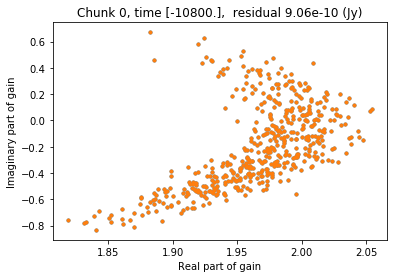

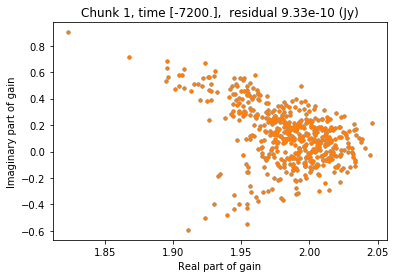

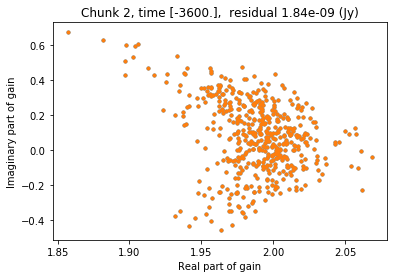

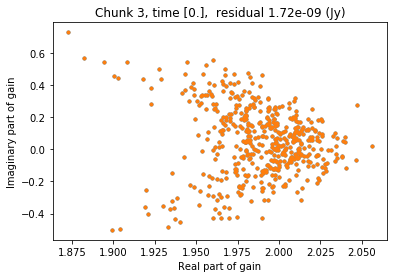

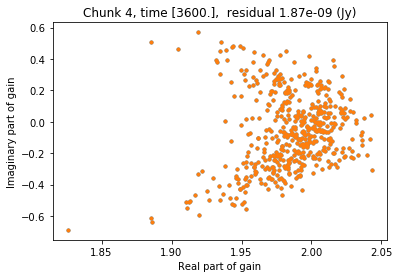

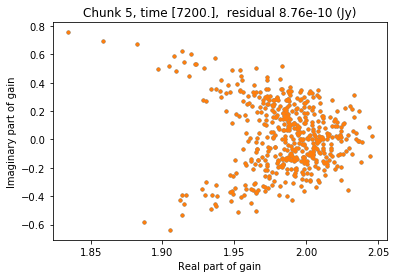

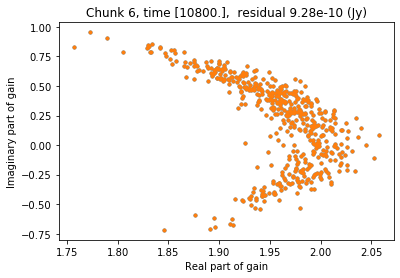

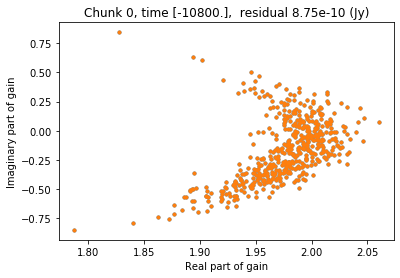

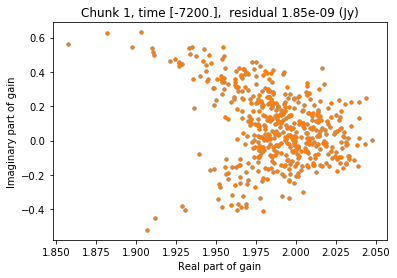

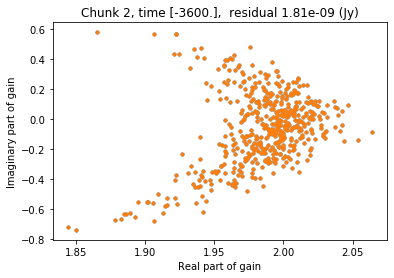

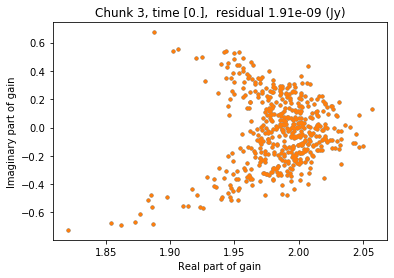

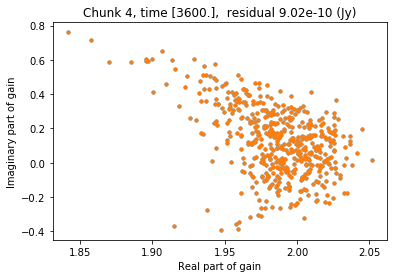

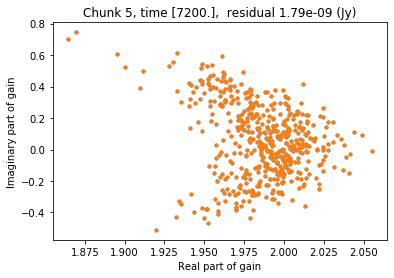

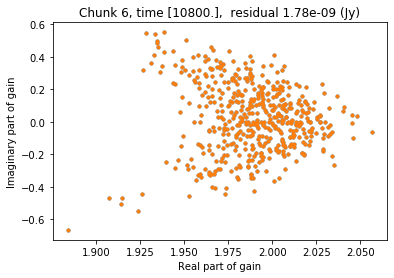

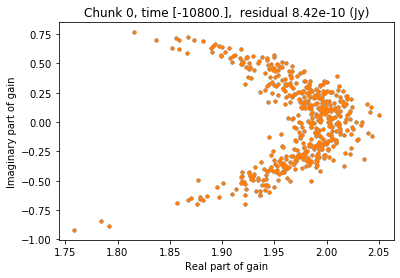

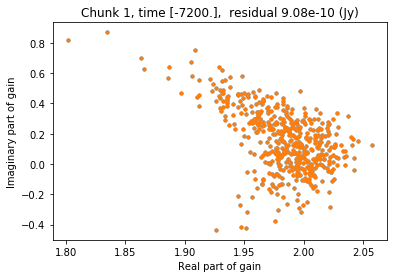

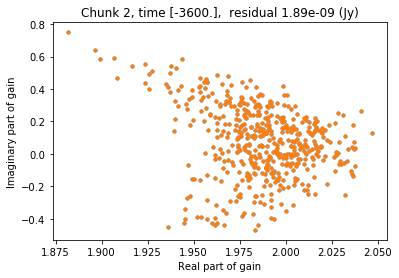

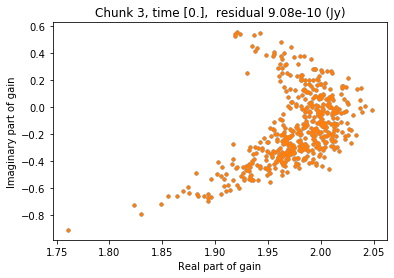

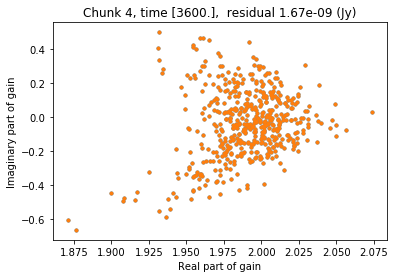

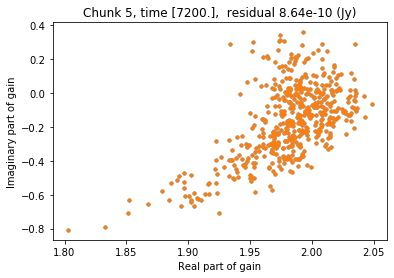

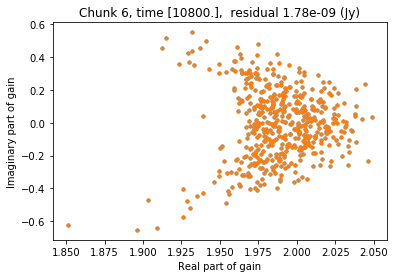

In [ ]:
for ingest in iter(csp_queue.get, None):
    sb_id = ingest[0]
    print("Processing SB_ID:", sb_id, "(", csp_queue.qsize(), "items left in CSP queue )")
    rcal_pipeline = rcal(vis=ingest[1], components=comp, phase_only=False)

    print("Starting pipeline")
    for igt, gt in enumerate(rcal_pipeline):
        plotgain(gt, title="Chunk %d, time %s,  residual %.3g (Jy)" % (igt, numpy.unique(gt.time),
                                                                   numpy.average(gt.residual)))
        tm_queue.put( [sb_id, qa_gaintable(gt)] )

    print("Ingest and RCAL pipelines are empty, stopping")

print("CSP Queue is empty, stopping")
csp_queue.join()